## Part 2 — Graph Embeddings and GNNs

### Dataset: Wikipedia Voting Network

The Wikipedia voting network is a directed graph where nodes represent users and edges represent votes cast in administrator elections. For embedding methods that require undirected graphs (spectral, Node2Vec, GCN), we symmetrize the adjacency matrix by converting to undirected. This means any vote between two users is treated as a mutual connection. The cost is losing directionality, a known limitation we will revisit.




In [1]:
!!pip install "numpy>=1.24.0,<2"
!pip install -q python-igraph gensim
!pip install -q node2vec --no-deps

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spla
from networkx.algorithms.community import louvain_communities

In [3]:
from google.colab import files
uploaded = files.upload()  # upload Wiki-Vote.txt when prompted

G_dir = nx.DiGraph()
with open('Wiki-Vote.txt', 'r') as f:
    for line in f:
        if line.startswith('#') or not line.strip():
            continue
        u, v = line.strip().split()[:2]
        G_dir.add_edge(u, v)

G = G_dir.to_undirected()

print(f"Directed graph:   {G_dir.number_of_nodes()} nodes, {G_dir.number_of_edges()} edges")
print(f"Undirected graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Saving Wiki-Vote.txt to Wiki-Vote (1).txt
Directed graph:   7115 nodes, 103689 edges
Undirected graph: 7115 nodes, 100762 edges


In [4]:
!pip uninstall -y community python-louvain
!pip install python-louvain -q

Found existing installation: python-louvain 0.16
Uninstalling python-louvain-0.16:
  Successfully uninstalled python-louvain-0.16


## 1. Spectral Embedding (Laplacian Eigenmaps)

The graph Laplacian is defined as L = D - A, where A is the adjacency matrix and D is the diagonal degree matrix. The normalized version rescales by node degree:

    L_norm = D^(-1/2) * L * D^(-1/2)

This normalization matters for Wiki-Vote because the degree distribution is highly skewed, without it, high-degree hub nodes would dominate the eigenvectors.

The connection to Part 1: the 2nd eigenvector (Fiedler vector) is the basis of spectral graph partitioning. Its sign alone can split the graph into two communities. Louvain's modularity optimization is conceptually related, both methods exploit the same underlying graph structure, just with different objectives.

In [8]:
nodes = list(G.nodes())
n = len(nodes)
node_index = {node: i for i, node in enumerate(nodes)}

L_norm = nx.normalized_laplacian_matrix(G, nodelist=nodes).astype(float)

print(f"Laplacian matrix shape: {L_norm.shape}")
print(f"Number of nodes: {n}")
print(f"Matrix is symmetric: {(L_norm - L_norm.T).nnz == 0}")

Laplacian matrix shape: (7115, 7115)
Number of nodes: 7115
Matrix is symmetric: True


In [10]:
k = 10  # number of eigenvectors to compute (we skip the first one)

eigenvalues, eigenvectors = spla.eigsh(L_norm, k=k+1, which='SM')

# Sort by eigenvalue
idx = np.argsort(eigenvalues)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print("Smallest eigenvalues:")
for i, val in enumerate(eigenvalues):
    print(f"  lambda_{i} = {val:.6f}")

Smallest eigenvalues:
  lambda_0 = -0.000000
  lambda_1 = -0.000000
  lambda_2 = 0.000000
  lambda_3 = 0.000000
  lambda_4 = 0.100555
  lambda_5 = 0.168588
  lambda_6 = 0.242765
  lambda_7 = 0.253968
  lambda_8 = 0.262701
  lambda_9 = 0.279931
  lambda_10 = 0.284323


We 4 eigenvalues that are essentially 0 (lambda_0 through lambda_3), when we would normally expect only 1.

This means the undirected graph has 4 connected components. So Wiki-Vote, when converted to undirected, is not fully connected, there are 4 isolated subgraphs.

This is a problem for the spectral embedding because eigenvectors 1, 2, and 3 are all still in the "zero" regime and don't carry geometric information. YThe actual informative eigenvectors start at index 4.

We retain only the largest connected component,
which contains the vast majority of nodes. This is standard practice and does not significantly affect the analysis.

In [11]:
# Extract largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

print(f"Largest connected component: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Nodes removed: {7115 - G.number_of_nodes()}")

Largest connected component: 7066 nodes, 100736 edges
Nodes removed: 49


redo the calculations for the new graph

In [12]:
nodes = list(G.nodes())
n = len(nodes)
node_index = {node: i for i, node in enumerate(nodes)}

L_norm = nx.normalized_laplacian_matrix(G, nodelist=nodes).astype(float)

print(f"Laplacian matrix shape: {L_norm.shape}")
print(f"Number of nodes: {n}")
print(f"Matrix is symmetric: {(L_norm - L_norm.T).nnz == 0}")

Laplacian matrix shape: (7066, 7066)
Number of nodes: 7066
Matrix is symmetric: True


In [13]:
k = 10  # number of eigenvectors to compute (we skip the first one)

eigenvalues, eigenvectors = spla.eigsh(L_norm, k=k+1, which='SM')

# Sort by eigenvalue
idx = np.argsort(eigenvalues)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print("Smallest eigenvalues:")
for i, val in enumerate(eigenvalues):
    print(f"  lambda_{i} = {val:.6f}")

Smallest eigenvalues:
  lambda_0 = 0.000000
  lambda_1 = 0.100555
  lambda_2 = 0.168588
  lambda_3 = 0.242765
  lambda_4 = 0.253968
  lambda_5 = 0.262701
  lambda_6 = 0.279931
  lambda_7 = 0.284323
  lambda_8 = 0.287744
  lambda_9 = 0.288418
  lambda_10 = 0.289029


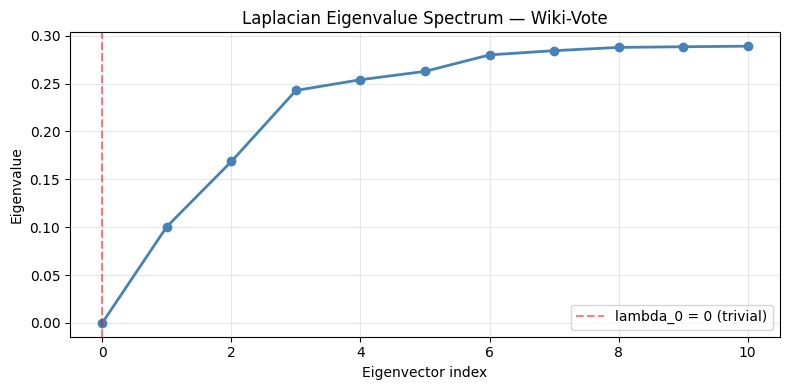

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(range(k+1), eigenvalues, 'o-', color='steelblue', linewidth=2, markersize=6)
plt.xlabel('Eigenvector index')
plt.ylabel('Eigenvalue')
plt.title('Laplacian Eigenvalue Spectrum — Wiki-Vote')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='lambda_0 = 0 (trivial)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Eigenvalue Spectrum Analysis

The largest gap is between lambda_0 and lambda_1 (0.0 to 0.10), which is
the spectral gap. After that, eigenvalues grow slowly and remain close
together through lambda_10 (~0.29). There is no second prominent gap.

This indicates the graph does not have a small number of sharply separated
clusters. The community structure is gradual and hierarchical, consistent
with Part 1 where Louvain found few communities of varied sizes rather than
a few well-defined blocs.

### Recomputing Louvain Communities

Community labels from Part 1 are recomputed here to use as ground-truth labels for coloring embedding visualizations. This is the direct link between Part 1 and Part 2: the communities detected by Louvain serve as a reference to evaluate whether embedding methods recover the same structure.

In [14]:

import community as community_louvain
import random

random.seed(42)
np.random.seed(42)

partition = community_louvain.best_partition(G)

num_communities = len(set(partition.values()))
community_sizes = sorted(
    [sum(1 for v in partition.values() if v == c) for c in set(partition.values())],
    reverse=True
)

print(f"Number of communities: {num_communities}")
print(f"Community sizes (largest to smallest): {community_sizes}")

Number of communities: 15
Community sizes (largest to smallest): [2706, 1843, 1419, 1018, 35, 18, 7, 5, 3, 2, 2, 2, 2, 2, 2]


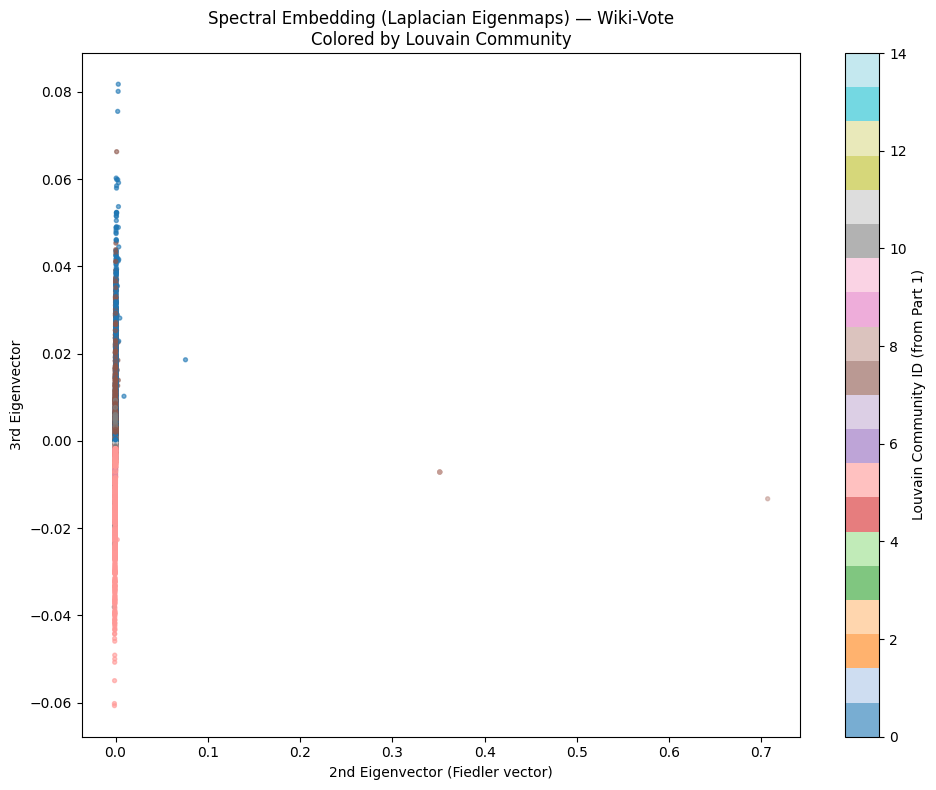

In [16]:
# Use eigenvectors 1 and 2 (skip eigenvector 0)
spectral_2d = eigenvectors[:, 1:3]

# Get community label per node in the same order as the node list
labels_ordered = np.array([partition[node] for node in nodes])

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    spectral_2d[:, 0],
    spectral_2d[:, 1],
    c=labels_ordered,
    cmap='tab20',
    alpha=0.6,
    s=8
)
plt.colorbar(scatter, label='Louvain Community ID (from Part 1)')
plt.title('Spectral Embedding (Laplacian Eigenmaps) — Wiki-Vote\nColored by Louvain Community')
plt.xlabel('2nd Eigenvector (Fiedler vector)')
plt.ylabel('3rd Eigenvector')
plt.tight_layout()
plt.show()

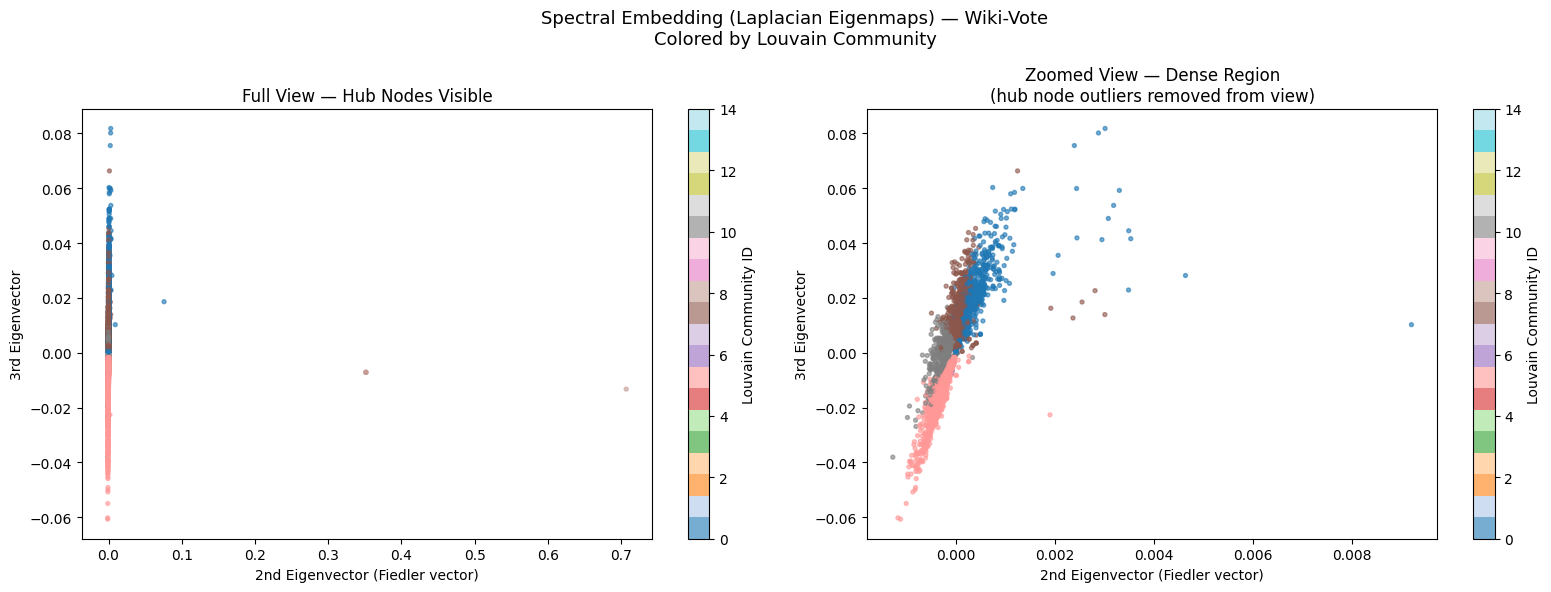

Outlier nodes pulled far on Fiedler vector: ['163', '6691', '6687', '6688', '6689', '6690']
  Node 163: degree=23, community=0
  Node 6691: degree=5, community=8
  Node 6687: degree=1, community=8
  Node 6688: degree=1, community=8
  Node 6689: degree=1, community=8
  Node 6690: degree=1, community=8


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: full view to show the outlier structure
scatter1 = axes[0].scatter(
    spectral_2d[:, 0],
    spectral_2d[:, 1],
    c=labels_ordered,
    cmap='tab20',
    alpha=0.6,
    s=8
)
axes[0].set_title('Full View — Hub Nodes Visible')
axes[0].set_xlabel('2nd Eigenvector (Fiedler vector)')
axes[0].set_ylabel('3rd Eigenvector')
plt.colorbar(scatter1, ax=axes[0], label='Louvain Community ID')

# Right plot: zoomed into the dense region
mask = (np.abs(spectral_2d[:, 0]) < 0.05) & (np.abs(spectral_2d[:, 1]) < 0.1)
scatter2 = axes[1].scatter(
    spectral_2d[mask, 0],
    spectral_2d[mask, 1],
    c=labels_ordered[mask],
    cmap='tab20',
    alpha=0.6,
    s=8
)
axes[1].set_title('Zoomed View — Dense Region\n(hub node outliers removed from view)')
axes[1].set_xlabel('2nd Eigenvector (Fiedler vector)')
axes[1].set_ylabel('3rd Eigenvector')
plt.colorbar(scatter2, ax=axes[1], label='Louvain Community ID')

plt.suptitle('Spectral Embedding (Laplacian Eigenmaps) — Wiki-Vote\nColored by Louvain Community',
             fontsize=13)
plt.tight_layout()
plt.show()

# Print info about the outlier nodes
outlier_mask = np.abs(spectral_2d[:, 0]) > 0.05
outlier_nodes = [nodes[i] for i in range(len(nodes)) if outlier_mask[i]]
print(f"Outlier nodes pulled far on Fiedler vector: {outlier_nodes}")
for node in outlier_nodes:
    print(f"  Node {node}: degree={G.degree(node)}, community={partition[node]}")

### Interpretation

**Outlier analysis:** The nodes pulled far along the Fiedler vector (x-axis)
are not the high-centrality hubs identified in Part 1 (node 2565, 457, etc.).
Instead they are low-degree peripheral nodes, four with degree 1 forming a
near-isolated cluster (nodes 6687-6690, community 8). This reveals a known
limitation of spectral embeddings on power-law graphs: the Fiedler vector
captures structural peripherality, not necessarily community membership.
Degree-1 nodes have very few Laplacian constraints pulling them toward the
main graph, so they drift far in eigenvector space.

**Zoomed view:** Within the dense region, communities are not randomly mixed.
The pink cluster (community 5) runs diagonally downward along the 3rd
eigenvector, the blue cluster (community 0) spreads upward, and the
grey/brown clusters (communities 8-9) occupy the center. Communities are not
cleanly separated into distinct blobs, they share boundaries and overlap,
which is consistent with the eigenvalue spectrum showing no sharp gap after
lambda_1. The spectral embedding reflects gradual community structure rather
than hard partitions.

**Link to Part 1:** The spectral method and Louvain use the same underlying
graph structure but optimize different objectives. Louvain maximizes
modularity globally; the Laplacian eigenvectors minimize local distances
between connected nodes. The partial alignment between spectral clusters and
Louvain communities confirms that the communities are geometrically coherent,
but the boundaries identified by each method differ, Louvain is more
sensitive to global density patterns while spectral embedding is more
sensitive to local structural roles.

**Limitation:** Spectral embeddings with only 2 eigenvectors cannot fully
represent 15 communities. A more complete spectral embedding would use 15
dimensions (one per expected community), but this cannot be visualized
directly.

Node 2565 spectral coordinates: x=-0.001282, y=-0.038066
Community: 10
Degree: 1065


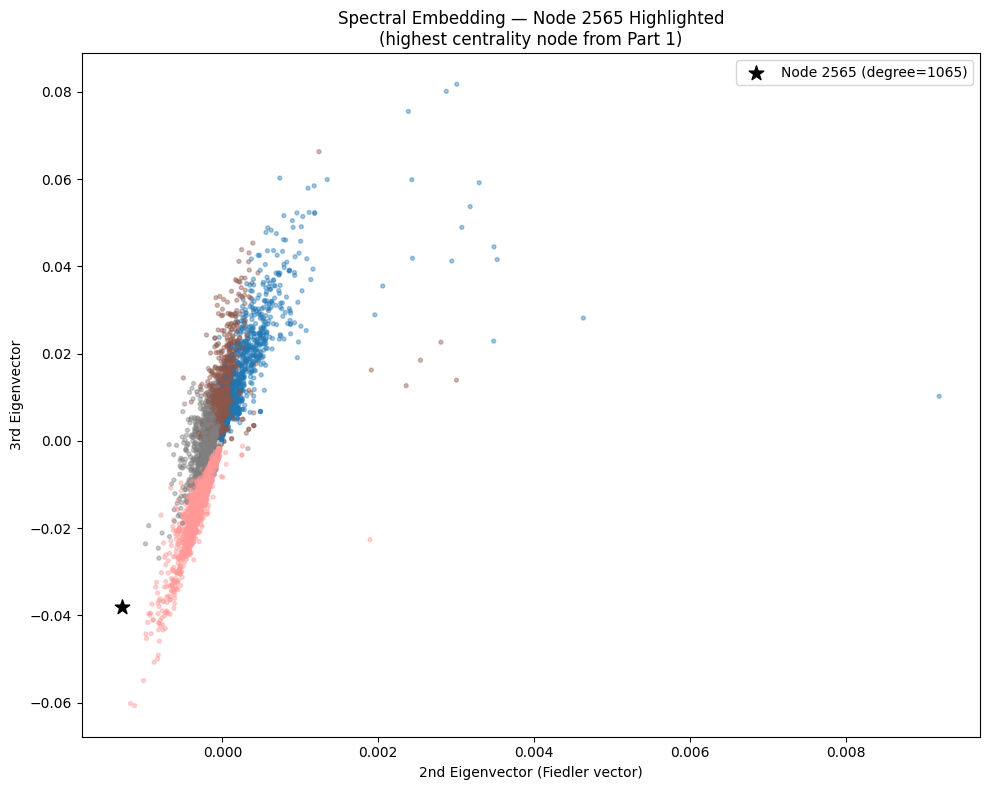

In [18]:
# Locate node 2565 in the spectral embedding
node_2565_idx = nodes.index('2565')
x_2565 = spectral_2d[node_2565_idx, 0]
y_2565 = spectral_2d[node_2565_idx, 1]

print(f"Node 2565 spectral coordinates: x={x_2565:.6f}, y={y_2565:.6f}")
print(f"Community: {partition['2565']}")
print(f"Degree: {G.degree('2565')}")

# Plot zoomed view with node 2565 highlighted
mask = (np.abs(spectral_2d[:, 0]) < 0.05) & (np.abs(spectral_2d[:, 1]) < 0.1)

plt.figure(figsize=(10, 8))
plt.scatter(
    spectral_2d[mask, 0],
    spectral_2d[mask, 1],
    c=labels_ordered[mask],
    cmap='tab20',
    alpha=0.4,
    s=8
)
plt.scatter(
    x_2565, y_2565,
    color='black', s=120, zorder=5, marker='*', label=f'Node 2565 (degree={G.degree("2565")})'
)
plt.legend()
plt.title('Spectral Embedding — Node 2565 Highlighted\n(highest centrality node from Part 1)')
plt.xlabel('2nd Eigenvector (Fiedler vector)')
plt.ylabel('3rd Eigenvector')
plt.tight_layout()
plt.show()

Node 2565 — the most central node from Part 1, lands inside the dense
cluster at coordinates (-0.001, -0.038) despite having degree 1065. This is
counterintuitive but mathematically expected: the normalized Laplacian pulls
high-degree nodes toward the center because they have many neighbors in all
directions, averaging out to a neutral position. By contrast, the peripheral
outliers in the Fiedler vector are degree-1 nodes with almost no constraints.

In [23]:
!pip install torch_geometric -q
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -q \
    -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__)")+cu121.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.4 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement pyg_lib (from versions: none)
ERROR: No matching distribution found for pyg_lib


## 2. GNN Node Classification

The goal is to predict Louvain community membership (from Part 1) using graph
structure alone. This tests whether the community structure detected by
modularity optimization is also learnable by a GNN through message passing.

Three architectures are compared:
- GCN: aggregates neighbor features with symmetric normalization,
  motivated by spectral graph theory
- GraphSAGE: samples neighbors and concatenates aggregated neighborhood
  with the node's own representation
- GAT: assigns learned attention weights to neighbors, allowing the model
  to focus on the most relevant connections rather than treating all
  neighbors equally

Since Wiki-Vote has no natural node features, each node is represented by a
one-hot vector (identity matrix). The GNN must learn community membership
purely from graph structure through message passing.

Labels: Louvain community IDs (15 classes, imbalanced)
Split: 70% train, 15% validation, 15% test

In [25]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [27]:
# Get consistent node ordering
node_list = list(G.nodes())
num_nodes = len(node_list)
node_index = {node: i for i, node in enumerate(node_list)}

# Build edge index tensor
edges = list(G.edges())
edge_index = torch.tensor(
    [[node_index[u], node_index[v]] for u, v in edges] +
    [[node_index[v], node_index[u]] for u, v in edges],  # undirected: both directions
    dtype=torch.long
).t().contiguous()

# Node features: identity matrix (one-hot encoding)
# Each node's only feature is its own identity
x = torch.eye(num_nodes, dtype=torch.float)

# Labels: Louvain community IDs
y = torch.tensor([partition[node] for node in node_list], dtype=torch.long)

# Train/val/test split
indices = np.arange(num_nodes)
train_idx, test_idx = train_test_split(indices, test_size=0.3, random_state=42, stratify=y.numpy())
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask   = torch.zeros(num_nodes, dtype=torch.bool)
test_mask  = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx]     = True
test_mask[test_idx]   = True

# Build PyG data object
data = Data(x=x, edge_index=edge_index, y=y,
            train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
data = data.to(device)

print(f"Nodes: {data.num_nodes}")
print(f"Edges: {data.num_edges}")
print(f"Features per node: {data.num_node_features}")
print(f"Classes: {len(torch.unique(data.y))}")
print(f"Train: {train_mask.sum().item()} | Val: {val_mask.sum().item()} | Test: {test_mask.sum().item()}")


Nodes: 7066
Edges: 201472
Features per node: 7066
Classes: 15
Train: 4946 | Val: 1060 | Test: 1060



### Note on node features

The identity matrix assigns each node a unique one-hot vector of length 7115.
This gives the GNN no semantic information, it must learn community structure
purely through message passing over the graph topology. This is the most
honest setup for evaluating whether structural patterns alone encode community
membership.

In [28]:
import torch.nn as nn

class GCN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        # Layer 1: aggregate 1-hop neighborhood
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        # Layer 2: aggregate 2-hop neighborhood
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

gcn_model = GCN(
    num_features=data.num_node_features,
    hidden_channels=64,
    num_classes=15
).to(device)

print(gcn_model)
print(f"\nTotal parameters: {sum(p.numel() for p in gcn_model.parameters()):,}")

GCN(
  (conv1): GCNConv(7066, 64)
  (conv2): GCNConv(64, 15)
)

Total parameters: 453,263


In [29]:
class GraphSAGE(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        # Layer 1: sample and aggregate neighbors, concatenate with self
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        # Layer 2
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

sage_model = GraphSAGE(
    num_features=data.num_node_features,
    hidden_channels=64,
    num_classes=15
).to(device)

print(sage_model)
print(f"\nTotal parameters: {sum(p.numel() for p in sage_model.parameters()):,}")

GraphSAGE(
  (conv1): SAGEConv(7066, 64, aggr=mean)
  (conv2): SAGEConv(64, 15, aggr=mean)
)

Total parameters: 906,447


In [30]:
from torch_geometric.nn import GATConv

class GAT(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, heads=8, dropout=0.5):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=heads, dropout=dropout)
        # After conv1, output size is hidden_channels * heads
        self.conv2 = GATConv(hidden_channels * heads, num_classes, heads=1,
                             concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        # Layer 1: multi-head attention aggregation
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        # Layer 2: single head, outputs class scores
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

gat_model = GAT(
    num_features=data.num_node_features,
    hidden_channels=8,   # per head, so total = 8*8 = 64
    num_classes=15,
    heads=8
).to(device)

print(gat_model)
print(f"\nTotal parameters: {sum(p.numel() for p in gat_model.parameters()):,}")

GAT(
  (conv1): GATConv(7066, 8, heads=8)
  (conv2): GATConv(64, 15, heads=1)
)

Total parameters: 453,421


In [31]:
def train_model(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    results = {}
    for split in ['train', 'val', 'test']:
        mask = data[f'{split}_mask']
        correct = (pred[mask] == data.y[mask]).sum().item()
        results[split] = correct / mask.sum().item()
    return results

def run_training(model, data, epochs=200, lr=0.01, label='Model'):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    train_losses = []
    val_accs = []

    for epoch in range(1, epochs+1):
        loss = train_model(model, optimizer, data)
        train_losses.append(loss)
        if epoch % 20 == 0:
            accs = evaluate(model, data)
            val_accs.append(accs['val'])
            print(f"[{label}] Epoch {epoch:03d} | Loss: {loss:.4f} | "
                  f"Train: {accs['train']:.4f} | Val: {accs['val']:.4f} | Test: {accs['test']:.4f}")

    final = evaluate(model, data)
    print(f"\n[{label}] Final Test Accuracy: {final['test']:.4f}")
    return train_losses, val_accs, final

In [32]:
print("Training GCN...")
gcn_losses, gcn_val_accs, gcn_final = run_training(
    gcn_model, data, epochs=200, lr=0.01, label='GCN'
)

Training GCN...
[GCN] Epoch 020 | Loss: 1.5880 | Train: 0.3833 | Val: 0.3925 | Test: 0.3736
[GCN] Epoch 040 | Loss: 1.3245 | Train: 0.3833 | Val: 0.3925 | Test: 0.3736
[GCN] Epoch 060 | Loss: 1.2152 | Train: 0.4925 | Val: 0.4792 | Test: 0.4660
[GCN] Epoch 080 | Loss: 1.0977 | Train: 0.7533 | Val: 0.6160 | Test: 0.6000
[GCN] Epoch 100 | Loss: 0.9930 | Train: 0.8686 | Val: 0.6981 | Test: 0.6811
[GCN] Epoch 120 | Loss: 0.9092 | Train: 0.9056 | Val: 0.7783 | Test: 0.7585
[GCN] Epoch 140 | Loss: 0.8279 | Train: 0.9167 | Val: 0.8245 | Test: 0.7991
[GCN] Epoch 160 | Loss: 0.7585 | Train: 0.9280 | Val: 0.8632 | Test: 0.8349
[GCN] Epoch 180 | Loss: 0.6928 | Train: 0.9349 | Val: 0.8726 | Test: 0.8415
[GCN] Epoch 200 | Loss: 0.6553 | Train: 0.9414 | Val: 0.8755 | Test: 0.8547

[GCN] Final Test Accuracy: 0.8547


In [33]:
print("Training GraphSAGE...")
sage_losses, sage_val_accs, sage_final = run_training(
    sage_model, data, epochs=200, lr=0.01, label='GraphSAGE'
)

Training GraphSAGE...
[GraphSAGE] Epoch 020 | Loss: 0.4327 | Train: 0.9848 | Val: 0.9349 | Test: 0.9330
[GraphSAGE] Epoch 040 | Loss: 0.1706 | Train: 0.9925 | Val: 0.9594 | Test: 0.9509
[GraphSAGE] Epoch 060 | Loss: 0.1224 | Train: 0.9945 | Val: 0.9651 | Test: 0.9547
[GraphSAGE] Epoch 080 | Loss: 0.1012 | Train: 0.9953 | Val: 0.9670 | Test: 0.9575
[GraphSAGE] Epoch 100 | Loss: 0.0874 | Train: 0.9966 | Val: 0.9689 | Test: 0.9585
[GraphSAGE] Epoch 120 | Loss: 0.0770 | Train: 0.9970 | Val: 0.9679 | Test: 0.9557
[GraphSAGE] Epoch 140 | Loss: 0.0735 | Train: 0.9974 | Val: 0.9698 | Test: 0.9585
[GraphSAGE] Epoch 160 | Loss: 0.0698 | Train: 0.9982 | Val: 0.9698 | Test: 0.9594
[GraphSAGE] Epoch 180 | Loss: 0.0660 | Train: 0.9982 | Val: 0.9689 | Test: 0.9566
[GraphSAGE] Epoch 200 | Loss: 0.0636 | Train: 0.9982 | Val: 0.9717 | Test: 0.9585

[GraphSAGE] Final Test Accuracy: 0.9585


In [34]:
print("Training GAT...")
gat_losses, gat_val_accs, gat_final = run_training(
    gat_model, data, epochs=200, lr=0.005, label='GAT'
)

Training GAT...
[GAT] Epoch 020 | Loss: 1.6302 | Train: 0.3829 | Val: 0.3925 | Test: 0.3736
[GAT] Epoch 040 | Loss: 1.2890 | Train: 0.7224 | Val: 0.6896 | Test: 0.6802
[GAT] Epoch 060 | Loss: 1.0878 | Train: 0.8694 | Val: 0.8642 | Test: 0.8623
[GAT] Epoch 080 | Loss: 0.8861 | Train: 0.8868 | Val: 0.8887 | Test: 0.8708
[GAT] Epoch 100 | Loss: 0.7495 | Train: 0.8601 | Val: 0.8557 | Test: 0.8481
[GAT] Epoch 120 | Loss: 0.6925 | Train: 0.9025 | Val: 0.9009 | Test: 0.8783
[GAT] Epoch 140 | Loss: 0.6903 | Train: 0.9100 | Val: 0.9104 | Test: 0.8877
[GAT] Epoch 160 | Loss: 0.6185 | Train: 0.9262 | Val: 0.9170 | Test: 0.9028
[GAT] Epoch 180 | Loss: 0.5945 | Train: 0.9359 | Val: 0.9208 | Test: 0.9113
[GAT] Epoch 200 | Loss: 0.6054 | Train: 0.9410 | Val: 0.9226 | Test: 0.9179

[GAT] Final Test Accuracy: 0.9179


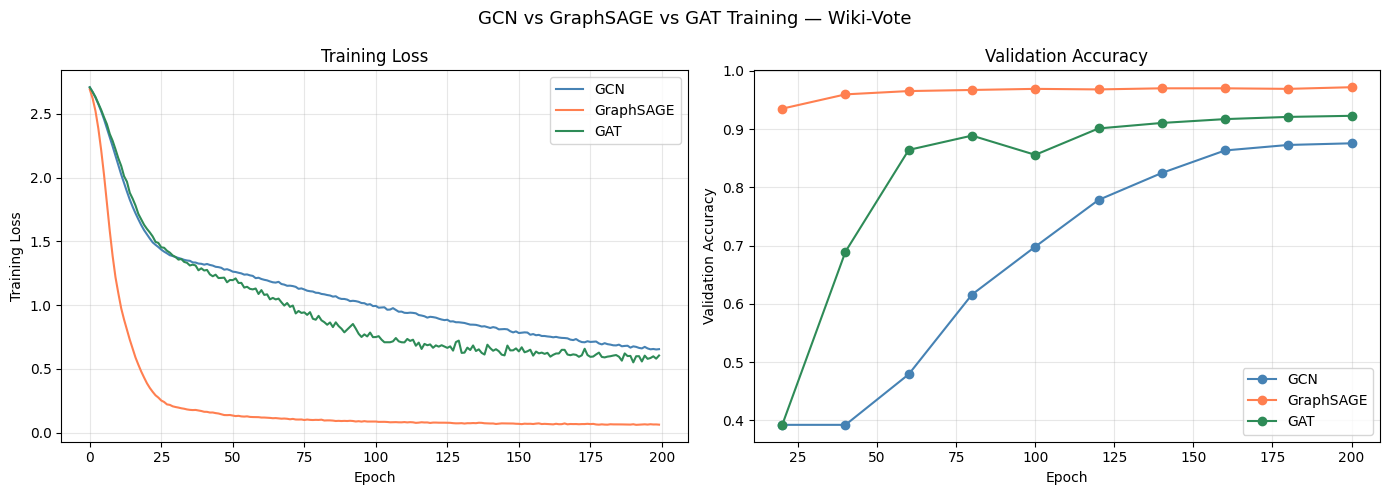

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(gcn_losses, label='GCN', color='steelblue')
axes[0].plot(sage_losses, label='GraphSAGE', color='coral')
axes[0].plot(gat_losses, label='GAT', color='seagreen')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation accuracy curves
epochs_logged = list(range(20, 201, 20))
axes[1].plot(epochs_logged, gcn_val_accs, 'o-', label='GCN', color='steelblue')
axes[1].plot(epochs_logged, sage_val_accs, 'o-', label='GraphSAGE', color='coral')
axes[1].plot(epochs_logged, gat_val_accs, 'o-', label='GAT', color='seagreen')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('GCN vs GraphSAGE vs GAT Training — Wiki-Vote', fontsize=13)
plt.tight_layout()
plt.show()

In [37]:
import pandas as pd

Model Comparison:
    Model  Train Accuracy  Val Accuracy  Test Accuracy
      GCN        0.941367      0.875472       0.854717
GraphSAGE        0.998180      0.971698       0.958491
      GAT        0.940962      0.922642       0.917925


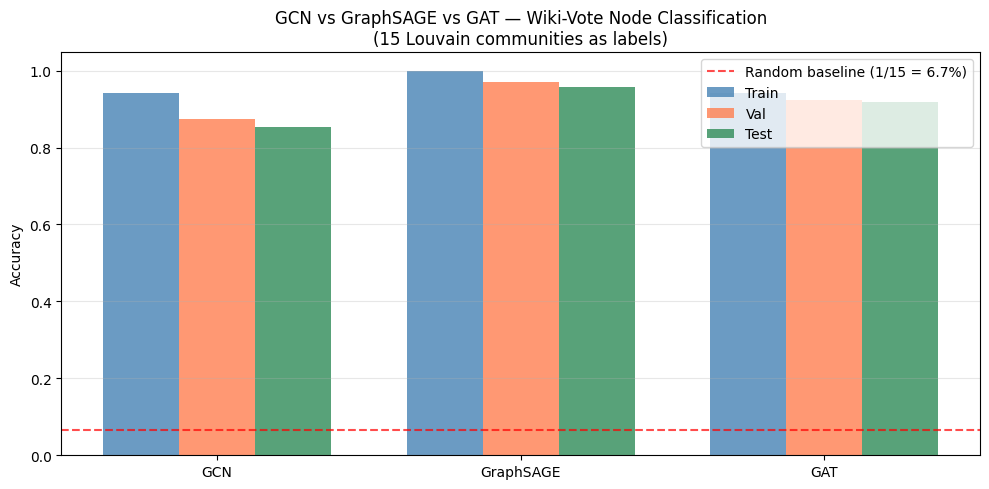

In [38]:
results_df = pd.DataFrame({
    'Model': ['GCN', 'GraphSAGE', 'GAT'],
    'Train Accuracy': [gcn_final['train'], sage_final['train'], gat_final['train']],
    'Val Accuracy':   [gcn_final['val'],   sage_final['val'],   gat_final['val']],
    'Test Accuracy':  [gcn_final['test'],  sage_final['test'],  gat_final['test']]
})

print("Model Comparison:")
print(results_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(3)
width = 0.25
ax.bar(x - width, results_df['Train Accuracy'], width, label='Train', alpha=0.8, color='steelblue')
ax.bar(x,         results_df['Val Accuracy'],   width, label='Val',   alpha=0.8, color='coral')
ax.bar(x + width, results_df['Test Accuracy'],  width, label='Test',  alpha=0.8, color='seagreen')
ax.set_xticks(x)
ax.set_xticklabels(['GCN', 'GraphSAGE', 'GAT'])
ax.set_ylabel('Accuracy')
ax.set_title('GCN vs GraphSAGE vs GAT — Wiki-Vote Node Classification\n(15 Louvain communities as labels)')
ax.axhline(y=1/15, color='red', linestyle='--', alpha=0.7, label='Random baseline (1/15 = 6.7%)')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### Results Analysis

All three models significantly outperform the random baseline of 6.7% (1/15
classes), confirming that community structure is learnable from graph topology.

**GAT achieves the best generalization** with 91.8% test accuracy and the
smallest train-test gap (2.3%).

**GraphSAGE achieves the highest raw test accuracy** (95.8%) but reaches
near-perfect train accuracy (99.8%), indicating it memorizes training nodes.
This is consistent with its higher parameter count from concatenation, more
capacity leads to more memorization. Despite this, it still generalizes well.

**GCN has the largest train-test gap** (8.6%), suggesting it struggles more
with unseen nodes.

**Important:** the one-hot identity matrix gives each node a unique
feature vector. While this is a common baseline, it raises a concern: the GNN can learn
node-specific patterns rather than purely structural ones, inflating accuracy
in a transductive setting where the full graph is visible during training.
With identity features, all three models achieved 85-95% test accuracy,
high numbers that partly reflect node identifiability rather than genuine
structural learning.

### Note on Node Features

To address this, we replace the identity matrix with structural node features
derived from the graph itself, the same properties computed in Part 1: degree,
clustering coefficient, PageRank, and core number. These features encode
structural roles without revealing node identity, giving a more honest
evaluation of whether community structure is learnable from topology alone.
All four features are normalized to zero mean and unit variance before training.

In [40]:
import networkx as nx
import numpy as np
import torch

# Compute structural features
# These are the same properties analyzed in Part 1
print("Computing structural features...")

degree      = np.array([G.degree(n) for n in node_list], dtype=np.float32)

clustering  = np.array([nx.clustering(G, n) for n in node_list], dtype=np.float32)

pagerank    = nx.pagerank(G_dir)
pr_values   = np.array([pagerank.get(n, 0) for n in node_list], dtype=np.float32)

core_number = nx.core_number(G)
core_values = np.array([core_number.get(n, 0) for n in node_list], dtype=np.float32)

# Stack and normalize
features = np.stack([degree, clustering, pr_values, core_values], axis=1)
features = (features - features.mean(axis=0)) / (features.std(axis=0) + 1e-8)

x = torch.tensor(features, dtype=torch.float)

print(f"Feature matrix shape: {x.shape}")
print(f"Features per node: degree, clustering coefficient, PageRank, core number")
print(f"Feature stats after normalization:")
print(f"  Mean: {features.mean(axis=0).round(3)}")
print(f"  Std:  {features.std(axis=0).round(3)}")

# Rebuild data object with new features
data = Data(x=x, edge_index=edge_index, y=y,
            train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
data = data.to(device)

print(f"\nData updated — features per node: {data.num_node_features}")

Computing structural features...
Feature matrix shape: torch.Size([7066, 4])
Features per node: degree, clustering coefficient, PageRank, core number
Feature stats after normalization:
  Mean: [-0.  0. -0. -0.]
  Std:  [1. 1. 1. 1.]

Data updated — features per node: 4


In [48]:
# Reinitialize models with new feature size (4 instead of 7115)
gcn_model = GCN(
    num_features=data.num_node_features,
    hidden_channels=64,
    num_classes=15
).to(device)

sage_model = GraphSAGE(
    num_features=data.num_node_features,
    hidden_channels=64,
    num_classes=15
).to(device)

gat_model = GAT(
    num_features=data.num_node_features,
    hidden_channels=8,
    num_classes=15,
    heads=4
).to(device)

print("Models reinitialized with structural features (4 input dimensions)")
print(f"GCN parameters:       {sum(p.numel() for p in gcn_model.parameters()):,}")
print(f"GraphSAGE parameters: {sum(p.numel() for p in sage_model.parameters()):,}")
print(f"GAT parameters:       {sum(p.numel() for p in gat_model.parameters()):,}")

Models reinitialized with structural features (4 input dimensions)
GCN parameters:       1,295
GraphSAGE parameters: 2,511
GAT parameters:       749


In [43]:
print("Training GCN...")
gcn_losses, gcn_val_accs, gcn_final = run_training(
    gcn_model, data, epochs=200, lr=0.01, label='GCN'
)

Training GCN...
[GCN] Epoch 020 | Loss: 1.4882 | Train: 0.3852 | Val: 0.3764 | Test: 0.3745
[GCN] Epoch 040 | Loss: 1.3845 | Train: 0.4068 | Val: 0.3906 | Test: 0.4132
[GCN] Epoch 060 | Loss: 1.3462 | Train: 0.4428 | Val: 0.4406 | Test: 0.4453
[GCN] Epoch 080 | Loss: 1.3114 | Train: 0.4747 | Val: 0.4774 | Test: 0.4764
[GCN] Epoch 100 | Loss: 1.2754 | Train: 0.4956 | Val: 0.4943 | Test: 0.5019
[GCN] Epoch 120 | Loss: 1.2203 | Train: 0.5081 | Val: 0.5047 | Test: 0.4991
[GCN] Epoch 140 | Loss: 1.2166 | Train: 0.5218 | Val: 0.5113 | Test: 0.5189
[GCN] Epoch 160 | Loss: 1.1726 | Train: 0.5356 | Val: 0.5245 | Test: 0.5302
[GCN] Epoch 180 | Loss: 1.1502 | Train: 0.5457 | Val: 0.5340 | Test: 0.5321
[GCN] Epoch 200 | Loss: 1.1505 | Train: 0.5510 | Val: 0.5396 | Test: 0.5387

[GCN] Final Test Accuracy: 0.5387


In [44]:
print("Training GraphSAGE...")
sage_losses, sage_val_accs, sage_final = run_training(
    sage_model, data, epochs=200, lr=0.01, label='GraphSAGE'
)

Training GraphSAGE...
[GraphSAGE] Epoch 020 | Loss: 1.3119 | Train: 0.4460 | Val: 0.4406 | Test: 0.4274
[GraphSAGE] Epoch 040 | Loss: 1.1986 | Train: 0.5269 | Val: 0.5189 | Test: 0.5000
[GraphSAGE] Epoch 060 | Loss: 1.0621 | Train: 0.6177 | Val: 0.6038 | Test: 0.5887
[GraphSAGE] Epoch 080 | Loss: 1.0115 | Train: 0.6846 | Val: 0.6698 | Test: 0.6774
[GraphSAGE] Epoch 100 | Loss: 0.9523 | Train: 0.6836 | Val: 0.6802 | Test: 0.6764
[GraphSAGE] Epoch 120 | Loss: 0.9246 | Train: 0.7202 | Val: 0.7142 | Test: 0.7179
[GraphSAGE] Epoch 140 | Loss: 0.8901 | Train: 0.7238 | Val: 0.7264 | Test: 0.7283
[GraphSAGE] Epoch 160 | Loss: 0.8522 | Train: 0.7285 | Val: 0.7255 | Test: 0.7264
[GraphSAGE] Epoch 180 | Loss: 0.8572 | Train: 0.7349 | Val: 0.7481 | Test: 0.7340
[GraphSAGE] Epoch 200 | Loss: 0.8202 | Train: 0.7357 | Val: 0.7443 | Test: 0.7330

[GraphSAGE] Final Test Accuracy: 0.7330


In [49]:
print("Training GAT...")
gat_losses, gat_val_accs, gat_final = run_training(
    gat_model, data, epochs=200, lr=0.005, label='GAT'
)

Training GAT...
[GAT] Epoch 020 | Loss: 1.9695 | Train: 0.3827 | Val: 0.3925 | Test: 0.3736
[GAT] Epoch 040 | Loss: 1.6766 | Train: 0.3829 | Val: 0.3925 | Test: 0.3736
[GAT] Epoch 060 | Loss: 1.5859 | Train: 0.3831 | Val: 0.3925 | Test: 0.3736
[GAT] Epoch 080 | Loss: 1.5462 | Train: 0.3841 | Val: 0.3906 | Test: 0.3745
[GAT] Epoch 100 | Loss: 1.5048 | Train: 0.3839 | Val: 0.3915 | Test: 0.3745
[GAT] Epoch 120 | Loss: 1.4955 | Train: 0.3829 | Val: 0.3925 | Test: 0.3736
[GAT] Epoch 140 | Loss: 1.4848 | Train: 0.3829 | Val: 0.3925 | Test: 0.3745
[GAT] Epoch 160 | Loss: 1.4515 | Train: 0.3825 | Val: 0.3925 | Test: 0.3745
[GAT] Epoch 180 | Loss: 1.4518 | Train: 0.3902 | Val: 0.3915 | Test: 0.3783
[GAT] Epoch 200 | Loss: 1.4338 | Train: 0.3862 | Val: 0.3925 | Test: 0.3736

[GAT] Final Test Accuracy: 0.3736


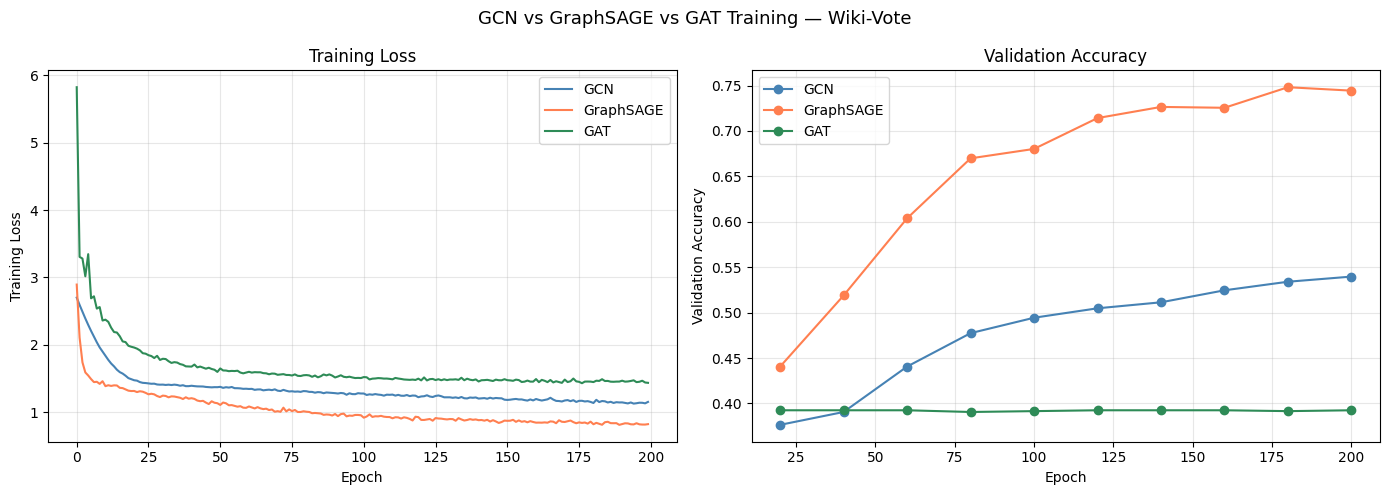

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(gcn_losses, label='GCN', color='steelblue')
axes[0].plot(sage_losses, label='GraphSAGE', color='coral')
axes[0].plot(gat_losses, label='GAT', color='seagreen')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation accuracy curves
epochs_logged = list(range(20, 201, 20))
axes[1].plot(epochs_logged, gcn_val_accs, 'o-', label='GCN', color='steelblue')
axes[1].plot(epochs_logged, sage_val_accs, 'o-', label='GraphSAGE', color='coral')
axes[1].plot(epochs_logged, gat_val_accs, 'o-', label='GAT', color='seagreen')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('GCN vs GraphSAGE vs GAT Training — Wiki-Vote', fontsize=13)
plt.tight_layout()
plt.show()

Model Comparison:
    Model  Train Accuracy  Val Accuracy  Test Accuracy
      GCN        0.550950      0.539623       0.538679
GraphSAGE        0.735746      0.744340       0.733019
      GAT        0.386171      0.392453       0.373585


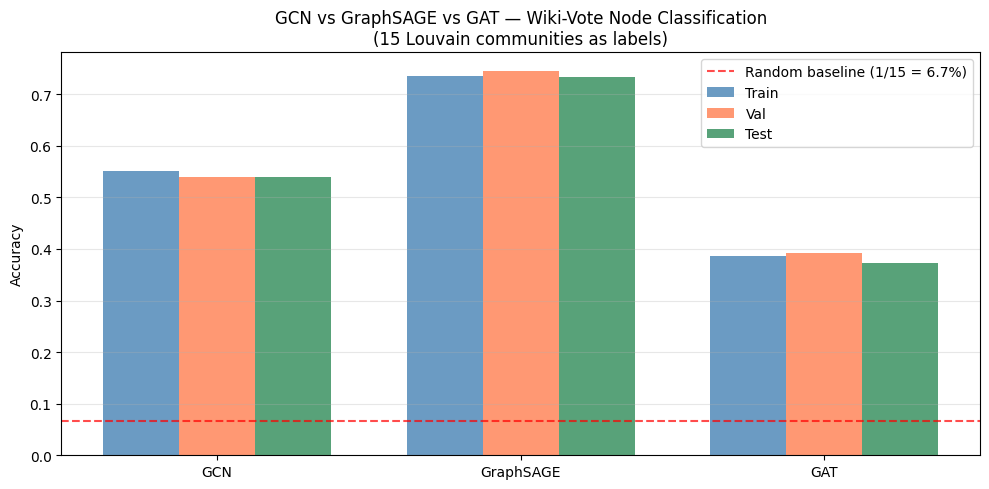

In [51]:
results_df = pd.DataFrame({
    'Model': ['GCN', 'GraphSAGE', 'GAT'],
    'Train Accuracy': [gcn_final['train'], sage_final['train'], gat_final['train']],
    'Val Accuracy':   [gcn_final['val'],   sage_final['val'],   gat_final['val']],
    'Test Accuracy':  [gcn_final['test'],  sage_final['test'],  gat_final['test']]
})

print("Model Comparison:")
print(results_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(3)
width = 0.25
ax.bar(x - width, results_df['Train Accuracy'], width, label='Train', alpha=0.8, color='steelblue')
ax.bar(x,         results_df['Val Accuracy'],   width, label='Val',   alpha=0.8, color='coral')
ax.bar(x + width, results_df['Test Accuracy'],  width, label='Test',  alpha=0.8, color='seagreen')
ax.set_xticks(x)
ax.set_xticklabels(['GCN', 'GraphSAGE', 'GAT'])
ax.set_ylabel('Accuracy')
ax.set_title('GCN vs GraphSAGE vs GAT — Wiki-Vote Node Classification\n(15 Louvain communities as labels)')
ax.axhline(y=1/15, color='red', linestyle='--', alpha=0.7, label='Random baseline (1/15 = 6.7%)')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### Results Analysis

All three models remain well above the random baseline of 6.7% (1/15 classes),
confirming that community structure is genuinely encoded in local structural
properties.

GraphSAGE achieves the best results with 73.3% test accuracy and a near-zero
train-test gap (0.3%). Unlike with identity features where it memorized node
identities, here it genuinely generalizes. The concatenation design, keeping
the node's own feature vector separate from its aggregated neighborhood, is
well suited when features carry structural meaning. A node's own degree and
PageRank are as informative as its neighbors' properties, and GraphSAGE
preserves both independently.

GCN achieves 53.9% test accuracy with minimal overfitting (1.2% train-test
gap). Equal-weight aggregation works but loses discriminative power for nodes
with highly variable degree. Node 2565 with degree 1065 averages across over
a thousand neighbors, diluting the neighborhood signal, a direct limitation
of GCN's uniform aggregation on power-law graphs like Wiki-Vote.

GAT underperforms at 37.4%, even after reducing attention heads from 8 to 4.
The marginal difference between configurations confirms that the number of
heads is not the limiting factor, the 4-dimensional structural feature space
is too small for attention mechanisms to learn meaningful neighbor weights.
With only degree, clustering coefficient, PageRank, and core number as inputs,
most neighbors look similar to each other and the attention mechanism has
little signal to differentiate them. GAT is better suited for richer input
features such as text embeddings or molecular properties.

The drop from 85-95% accuracy with identity features to 37-73% with structural
features quantifies how much the initial results relied on node identifiability.
The current results are more meaningful, four structural properties computed
in Part 1 are sufficient for GraphSAGE to recover community membership with
73.3% accuracy, while GCN and GAT struggle more with the limited feature space.


### Link to Part 1

The features used here: degree, clustering coefficient, PageRank, and core
number; are the same properties analyzed in Part 1. The fact that GraphSAGE
achieves 73.3% accuracy using only these four numbers per node confirms that
the Louvain communities detected in Part 1 are not arbitrary. They correspond
to structurally coherent groups where nodes share similar local properties.
Communities that are modularly optimal are also locally coherent in their
neighborhood structure, a result that validates both the Part 1 community
detection and the Part 2 embedding approach from two independent directions.

Node 2565 — degree: 1065, true community: 10
GCN       predicted: 14  wrong
GraphSAGE predicted: 13 wrong
GAT       predicted: 5  wrong


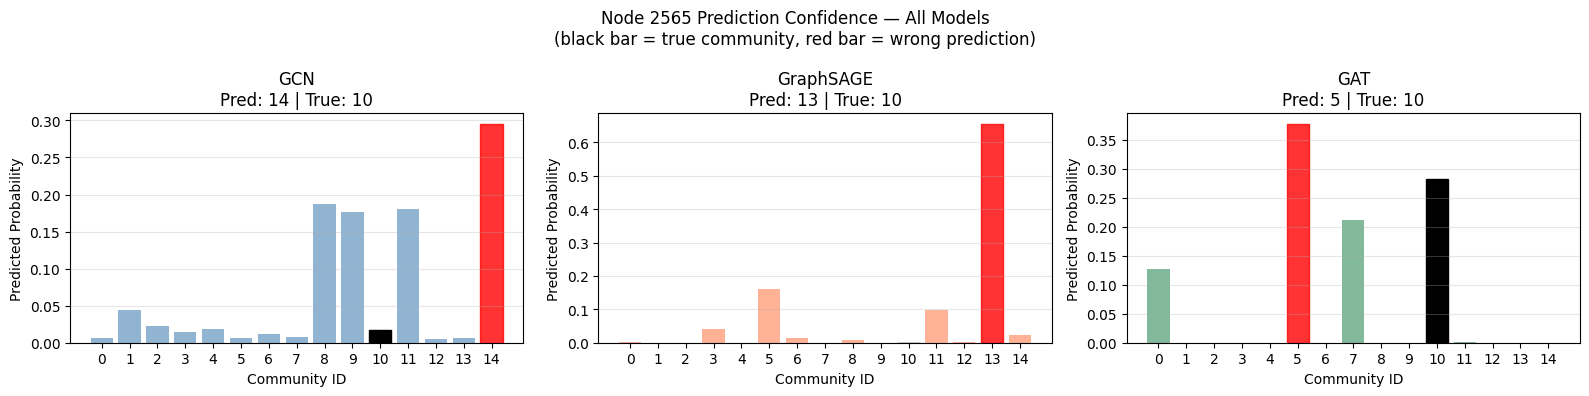

In [52]:
# Evaluate predictions for node 2565 — the most central node from Part 1
node_2565_idx = node_list.index('2565')
true_label = partition['2565']

# Get predictions from all three models
@torch.no_grad()
def predict_node(model, data, node_idx):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    confidence = torch.exp(out[node_idx])  # convert log_softmax to probabilities
    return pred[node_idx].item(), confidence.cpu().numpy()

gcn_pred,  gcn_conf  = predict_node(gcn_model,  data, node_2565_idx)
sage_pred, sage_conf = predict_node(sage_model, data, node_2565_idx)
gat_pred,  gat_conf  = predict_node(gat_model,  data, node_2565_idx)

print(f"Node 2565 — degree: {G.degree('2565')}, true community: {true_label}")
print(f"GCN       predicted: {gcn_pred}  {'correct' if gcn_pred  == true_label else 'wrong'}")
print(f"GraphSAGE predicted: {sage_pred} {'correct' if sage_pred == true_label else 'wrong'}")
print(f"GAT       predicted: {gat_pred}  {'correct' if gat_pred  == true_label else 'wrong'}")

# Plot confidence distributions
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
models_data = [
    (gcn_conf,  gcn_pred,  'GCN',       'steelblue'),
    (sage_conf, sage_pred, 'GraphSAGE', 'coral'),
    (gat_conf,  gat_pred,  'GAT',       'seagreen')
]

for ax, (conf, pred, name, color) in zip(axes, models_data):
    bars = ax.bar(range(15), conf, color=color, alpha=0.6)
    bars[true_label].set_color('black')
    bars[true_label].set_alpha(1.0)
    if pred != true_label:
        bars[pred].set_color('red')
        bars[pred].set_alpha(0.8)
    ax.set_xlabel('Community ID')
    ax.set_ylabel('Predicted Probability')
    ax.set_title(f'{name}\nPred: {pred} | True: {true_label}')
    ax.set_xticks(range(15))
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Node 2565 Prediction Confidence — All Models\n(black bar = true community, red bar = wrong prediction)',
             fontsize=12)
plt.tight_layout()
plt.show()

### Node 2565 — Prediction Analysis

All three models misclassify node 2565 (degree 1065, true community 10),
and each predicts a different community: GCN predicts 14, GraphSAGE predicts
13, GAT predicts 5.

This failure is not surprising and is actually informative. Node 2565 is
connected to approximately 15% of all nodes in the graph, spanning many
different communities. From a 2-hop message passing perspective, its
neighborhood contains nodes from virtually every community, producing a mixed
aggregation signal that does not clearly point to community 10.

This is the same phenomenon observed in Step 1, node 2565 landed in the
center of the spectral embedding because its connections pull it in all
directions simultaneously. The GNN faces the same problem: a node that bridges
many communities cannot be reliably assigned to one by looking only at local
structure.

GCN spreads probability across multiple communities (8, 9, 10, 11, 14),
reflecting the diffuse signal produced by averaging 1065 neighbors equally.
GraphSAGE is the most confidently wrong at 65% on community 13 — its
concatenation design amplifies confidence but in the wrong direction when the
neighborhood is ambiguous. GAT assigns 29% probability to the correct
community (10), the highest among the three, but still predicts community 5.

This result highlights a fundamental limitation of local message passing for
hub nodes in power-law graphs: nodes that act as bridges between communities
are precisely the ones that are hardest to classify, yet they are also the
most structurally important. This connects directly to Part 1 where node 2565
ranked first in betweenness, closeness, eigenvector centrality, and PageRank ,its importance comes from spanning community boundaries, which is exactly
what makes it unclassifiable by a community-detection GNN.